In [5]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import reverse_complement
from Bio.SeqUtils import GC

In [6]:
import pandas as pd
import numpy as np
import os, sys
from tqdm.notebook import tqdm
from importlib import reload
import re

In [7]:
# this version doesn't have ChromAn compiled, so directly load from src:
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares/ChromAn")
import src
reload(src)
from src.file_io.data_organization import create_folder
from src.parallel_tools.process_io import time_full

# save these candidate sequences:
probe_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS'
save_folder = os.path.join(probe_folder, 'RandomSeqBarcode_new')
save_separate_folder = os.path.join(save_folder, 'TargetProbe_separate')
# create 

create_folder(save_folder)
create_folder(save_separate_folder)

Folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new already exists
Folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/TargetProbe_separate already exists


## Load

In [4]:
output_folder = os.path.join(save_separate_folder, 'outputs')

max_len = 2800
ratios_mat = np.zeros([max_len, max_len, 8], dtype=np.float16)

for _i in range(max_len):
    
    ratio_file = os.path.join(output_folder, f"test_run_{_i}_logRatio.npy")
    if not os.path.exists(ratio_file):
        print(_i)
        continue
    ratios_list = np.load(ratio_file)
    ratios_mat[_i] = ratios_list[:max_len]

1226
1681
1691


In [5]:
mean_ratio_mat = np.mean(ratios_mat, 2) / np.log(10)

In [6]:
kept_inds = np.where((np.median(mean_ratio_mat, 0) < -2.5) & (np.median(mean_ratio_mat, 1) < -2.5))[0]

In [7]:
kept_mean_ratio_mat = mean_ratio_mat[kept_inds][:,kept_inds]

## Plot cross-hybridization ratio matrix (between candidate intBCs)

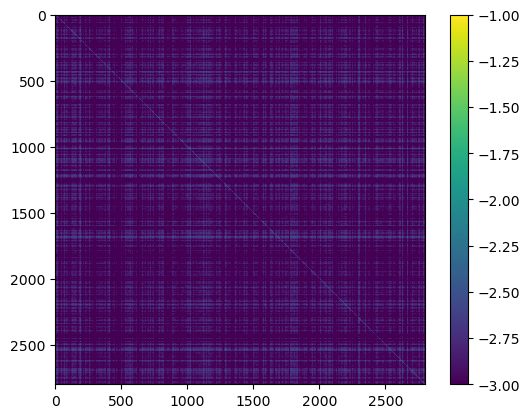

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(mean_ratio_mat, vmin=-3, vmax=-1)
plt.colorbar()
plt.show()

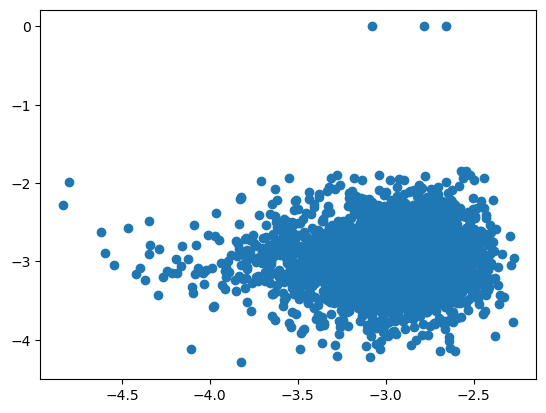

In [9]:
plt.scatter(np.median(mean_ratio_mat, 0), np.median(mean_ratio_mat, 1))

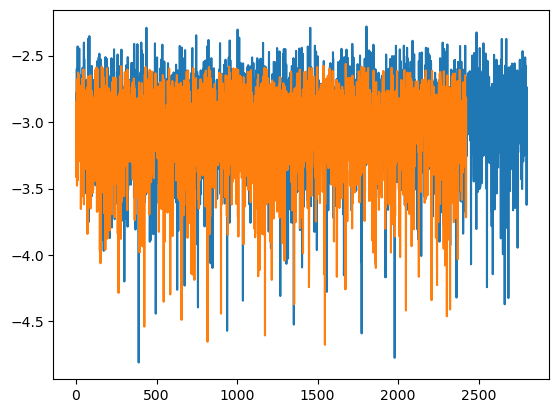

In [10]:
plt.figure()
plt.plot(mean_ratio_mat.mean(0))
plt.plot(kept_mean_ratio_mat.mean(0))

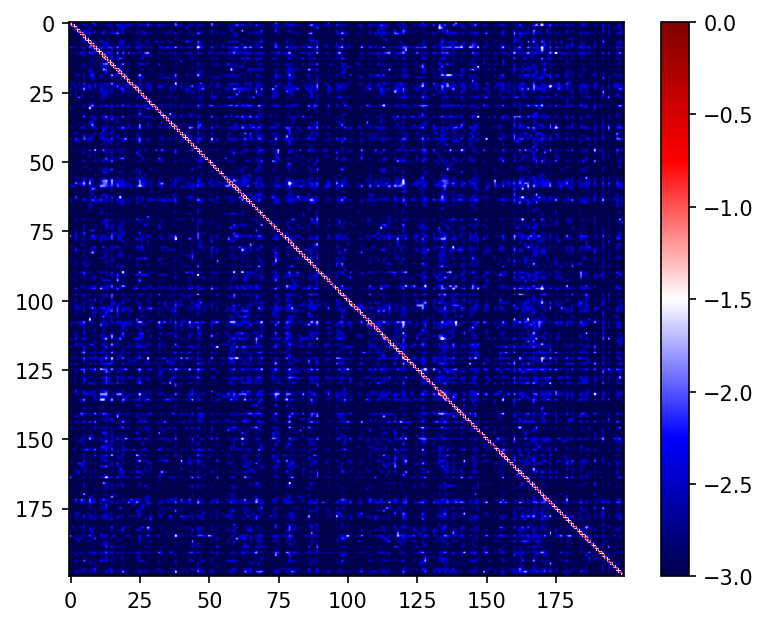

In [11]:
plt.figure(dpi=150)
plt.imshow(kept_mean_ratio_mat[:200,:200], vmin=-3,vmax=0, cmap='seismic', interpolation=None)
plt.colorbar()
plt.show()

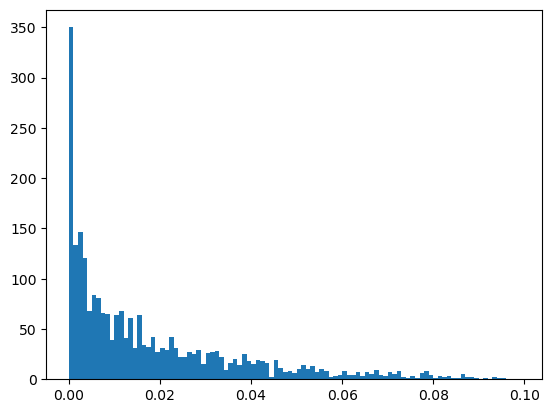

In [12]:
badHit_rates = ((kept_mean_ratio_mat > -2).sum(0)-1)/max_len
plt.figure()
plt.hist(badHit_rates, bins=np.arange(0,0.1,0.001))
plt.show()

In [13]:
np.max(badHit_rates)

0.09571428571428571

# Extract sequences given this crosstalk matrix

In [14]:
candidate_seq_df = pd.read_excel(os.path.join(save_folder, 'candidate_fullseqs.xlsx'))

In [15]:
candidate_seq_df

,Sequence
0,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
1,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
2,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
3,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
4,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
...,...
5965,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
5966,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
5967,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
5968,cgcctccccgcatcgatacctaatacgactcactatagggagagta...


In [16]:
candidate_seq_df

,Sequence
0,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
1,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
2,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
3,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
4,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
...,...
5965,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
5966,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
5967,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
5968,cgcctccccgcatcgatacctaatacgactcactatagggagagta...


# Screen for off-targets to other reference transcriptomes:m

## Load CountTable for rRNA + tRNA

In [11]:
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.IO.file_io as fio

import os
reference_folder = r'/lab/weissman_imaging/puzheng/Ensembl_references/RNA'

fasta_basenames = [_fl for _fl in os.listdir(reference_folder) if _fl.split(os.extsep)[-1] == 'fa']
genome_names = np.unique([_f.split('.')[0] for _f in fasta_basenames])
print(genome_names)
for _genome in genome_names:
    print(_genome)
    _rna_dfs = []
    for _fl in fasta_basenames:
        
        if _genome in _fl:
            _rna_dfs.append(fio.load_fasta_into_df(os.path.join(reference_folder, _fl)))
    
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(pd.concat(_rna_dfs), 17)
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(pd.concat(_rna_dfs), 17)
    

['Danio_rerio' 'Drosophila_melanogaster' 'Homo_sapiens' 'Mus_musculus']
Danio_rerio
Found 1990 rRNAs/tRNAs from 65890 non-coding RNAs.
Drosophila_melanogaster
Found 427 rRNAs/tRNAs from 35631 non-coding RNAs.
Homo_sapiens
Found 95 rRNAs/tRNAs from 273426 non-coding RNAs.
Mus_musculus
Found 378 rRNAs/tRNAs from 146157 non-coding RNAs.


## final screening against transcriptome

In [ ]:
from seqint import seq2Int,seq2Int_rc
from src.library_tools.design import countTable

In [58]:
sel_seq_filename = os.path.join(save_folder, 'filtered_fullseqs.xlsx')
if not os.path.exists(sel_seq_filename):
    print("- save")
    sel_seq_df = candidate_seq_df.iloc[kept_inds]
    sel_seq_df.to_excel(sel_seq_filename, index=None)
else:
    print("- load")
    sel_seq_df = pd.read_excel(sel_seq_filename)

- load


In [73]:
new_seqs = []
for _seq in sel_seq_df['Sequence']:
    # split upper and lower cases
    fwd, seq_primer, rev = re.split(r'[ATGC]+', _seq)
    designed_seqs = re.split(r'[atgc]+', _seq)[1:-1]
    new_seq = fwd[-33:] + designed_seqs[0][-183:] + seq_primer + designed_seqs[1] + rev[:33]
    new_seqs.append(new_seq)
sel_seq_df['New_Sequence'] = new_seqs

In [74]:
sel_seq_df

,Sequence,New_Sequence
0,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTGTATTTGTGAGG...
1,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaAGTTGCGAAGGTG...
2,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaCAGAGGTAGGCTG...
3,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTGTATACCACGCG...
4,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTCCAAAGTATGCG...
...,...,...
2418,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaACGGTACATAAAG...
2419,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTAATGTATACTTC...
2420,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaCCAGTGGATTCTA...
2421,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaCGTGTAACGTGAT...


In [75]:
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.IO.file_io as fio

import os
reference_folder = r'/lab/weissman_imaging/puzheng/Ensembl_references/RNA'

fasta_basenames = [_fl for _fl in os.listdir(reference_folder) if _fl.split(os.extsep)[-1] == 'fa']
genome_names = np.unique([_f.split('.')[0] for _f in fasta_basenames])
print(genome_names)
for _genome in genome_names:
    print(_genome)
    _rna_dfs = []
    for _fl in fasta_basenames:
        
        if _genome in _fl:
            _rna_dfs.append(fio.load_fasta_into_df(os.path.join(reference_folder, _fl)))
    transcriptome = pd.concat(_rna_dfs)
    transcriptome['FPKM'] = 1
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(transcriptome, 17)
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)
    
    rtrna_cts = []
    trans_cts = []
    for _seq in sel_seq_df['New_Sequence']:
        _rtrna_ct = np.sum([ottable_rtRNAs[_seq[_i:_i+17]] for _i in range(len(_seq)-17+1)])
        _transcriptome_ct = np.sum([ottable_transcriptome[_seq[_i:_i+17]] for _i in range(len(_seq)-17+1)])
        rtrna_cts.append(_rtrna_ct)
        trans_cts.append(_transcriptome_ct)
    # add col
    sel_seq_df[f"{_genome}_rtRNA"] = rtrna_cts
    sel_seq_df[f"{_genome}_transcriptome"] = trans_cts


['Danio_rerio' 'Drosophila_melanogaster' 'Homo_sapiens' 'Mus_musculus']
Danio_rerio
Found 1990 rRNAs/tRNAs from 65890 non-coding RNAs.
Construct a OTTable using 65890/65890 transcripts with FPKM > 0.
Processed 1000/65890 sequences.
Processed 2000/65890 sequences.
Processed 3000/65890 sequences.
Processed 4000/65890 sequences.
Processed 5000/65890 sequences.
Processed 6000/65890 sequences.
Processed 7000/65890 sequences.
Processed 8000/65890 sequences.
Processed 9000/65890 sequences.
Processed 10000/65890 sequences.
Processed 11000/65890 sequences.
Processed 12000/65890 sequences.
Processed 13000/65890 sequences.
Processed 14000/65890 sequences.
Processed 15000/65890 sequences.
Processed 16000/65890 sequences.
Processed 17000/65890 sequences.
Processed 18000/65890 sequences.
Processed 19000/65890 sequences.
Processed 20000/65890 sequences.
Processed 21000/65890 sequences.
Processed 22000/65890 sequences.
Processed 23000/65890 sequences.
Processed 24000/65890 sequences.
Processed 25000/6

In [119]:
sorted_sel_seq_df

,index,Sequence,New_Sequence,Danio_rerio_rtRNA,Danio_rerio_transcriptome,Drosophila_melanogaster_rtRNA,Drosophila_melanogaster_transcriptome,Homo_sapiens_rtRNA,Homo_sapiens_transcriptome,Mus_musculus_rtRNA,Mus_musculus_transcriptome,Total_transcriptome
0,0,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTGTATTTGTGAGG...,0,0,0,0,0,0,0,0,0
1,1852,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaGAGAGGCTTTGTT...,0,0,0,0,0,0,0,0,0
2,614,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaAGTGTAGAAGCCG...,0,0,0,0,0,0,0,0,0
3,611,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTGTGAGTTATGAA...,0,0,0,0,0,0,0,0,0
4,1859,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaCCTGACGGCACTA...,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2418,1891,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTGTGTCCTCCGGA...,0,4,0,1,0,72,0,8,85
2419,2005,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaTCGATTGGACCGC...,0,0,0,0,0,86,0,3,89
2420,1013,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaCCGTAGTGTTTAC...,0,0,0,4,0,89,0,4,97
2421,2135,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,aattaaccctcactaaagggataatttaattaaGGACCGGATCCGT...,0,1,0,0,0,105,0,8,114


In [77]:
counts = sel_seq_df.values[:,-8:]
rt_counts = counts[:,0::2]
rt_flags = rt_counts.sum(1) == 0

trans_counts = counts[:,1::2]
trans_flags = (trans_counts > 13).sum(1) == 0

In [78]:
final_flag = rt_flags & trans_flags

In [79]:
final_seq_df = sel_seq_df[final_flag]

In [ ]:
final_seq_filename = os.path.join(save_folder, '20230403-final_fullseqs.xlsx')
print(final_seq_filename)
final_seq_df.to_excel(final_seq_filename, index=None)

In [187]:
final_seq_df['Total_transcriptome'] = final_seq_df[[_c for _c in final_seq_df.columns if 'transcriptome' in _c]].sum(1)

sorted_final_seq_df = final_seq_df.sort_values('Total_transcriptome').reset_index()

/tmp/ipykernel_1741/1213236772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_seq_df['Total_transcriptome'] = final_seq_df[[_c for _c in final_seq_df.columns if 'transcriptome' in _c]].sum(1)


In [201]:
from src.library_tools.LibraryTools import seqrc
from copy import copy
final_sel_number = 2000
include_rc = True

_name_list = [f'newPE-TS-180_intBC{_i}' for _i in sorted_final_seq_df.index][:final_sel_number]
_seq_list = list(sorted_final_seq_df['New_Sequence'].values)[:final_sel_number]

if include_rc:
    _rc_name_list = [_n+'_rc' for _n in _name_list]
    _rc_seq_list = [seqrc(copy(_s)) for _s in _seq_list]
else:
    _rc_name_list, _rc_seq_list = [], []

twist_final_df = pd.DataFrame({'name':_name_list+_rc_name_list,
                               'sequence':_seq_list+_rc_seq_list})

In [205]:
twist_final_df

,name,sequence
0,newPE-TS-180_intBC0,aattaaccctcactaaagggataatttaattaaTGTATTTGTGAGG...
1,newPE-TS-180_intBC1,aattaaccctcactaaagggataatttaattaaGTGGTTCTGGTTA...
2,newPE-TS-180_intBC2,aattaaccctcactaaagggataatttaattaaCTCGGTTTACCGT...
3,newPE-TS-180_intBC3,aattaaccctcactaaagggataatttaattaaGCATGCTGGCTGG...
4,newPE-TS-180_intBC4,aattaaccctcactaaagggataatttaattaaTTTACATGCCCTG...
...,...,...
3995,newPE-TS-180_intBC1995_rc,gtcgtaatgactaagatgactgccattaattaaTCAACACGCTCGC...
3996,newPE-TS-180_intBC1996_rc,gtcgtaatgactaagatgactgccattaattaaCGTAGAAGGCGAA...
3997,newPE-TS-180_intBC1997_rc,gtcgtaatgactaagatgactgccattaattaaGGTATCTTAAGAA...
3998,newPE-TS-180_intBC1998_rc,gtcgtaatgactaagatgactgccattaattaaATTGTACCAATGA...


In [202]:
twist_final_df.loc[0,'sequence']

'aattaaccctcactaaagggataatttaattaaTGTATTTGTGAGGGCCCAACCACGACGTAAGGTGAATTGTTGCTGCGTTCAGTCGTAAATGTTCGGATTCGCCCTATATCTGTGGCGCACTAGCATTGAAGCTGTAATTCCTCCGTATTACACTAGTTACTTGAGGTAGCCGCCCTGTCTAGTTAATGCTATGCCCGGTCGACCGCGTGGAAAgaatccagctagctgtgcagcGTAACCAGTAAAGGAAATCGCGGTTGTCACttaattaatggcagtcatcttagtcattacgac'

In [203]:
twist_final_df.loc[2000,'sequence']

'gtcgtaatgactaagatgactgccattaattaaGTGACAACCGCGATTTCCTTTACTGGTTACgctgcacagctagctggattcTTTCCACGCGGTCGACCGGGCATAGCATTAACTAGACAGGGCGGCTACCTCAAGTAACTAGTGTAATACGGAGGAATTACAGCTTCAATGCTAGTGCGCCACAGATATAGGGCGAATCCGAACATTTACGACTGAACGCAGCAACAATTCACCTTACGTCGTGGTTGGGCCCTCACAAATACAttaattaaattatccctttagtgagggttaatt'

In [204]:
twist_filename = os.path.join(save_folder, '20230404-final_sorted_seqs_Twist.xlsx')
print(twist_filename)
twist_final_df.to_excel(twist_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/20230404-final_sorted_seqs_Twist.xlsx


# The following doesn't work because of lack of memory:

In [24]:
reference_folder = r'/lab/weissman_imaging/puzheng/Ensembl_references/'
for _fl in os.listdir(reference_folder):
    if _fl.split(os.extsep)[-1] == 'fa':
        print(_fl)

Drosophila_melanogaster.BDGP6.32.dna_sm.toplevel.fa
Danio_rerio.GRCz11.dna_sm.toplevel.fa
Mus_musculus.GRCm39.dna_sm.toplevel.fa
Homo_sapiens.GRCh38.dna_sm.toplevel.fa


In [ ]:
reference_folder = r'/lab/weissman_imaging/puzheng/Ensembl_references/'
for _fl in os.listdir(reference_folder):
    if _fl.split(os.extsep)[-1] == 'fa':
        print(_fl)
        
        table_savefile = os.path.join(reference_folder, _fl.replace('.fa', '_countTable.npy'))
        # init counTable
        _genome_table = countTable(word=17, save_file=table_savefile, verbose=False)
        if not os.path.exists(table_savefile):
            print("- calculate")
            _genome_table.read([os.path.join(reference_folder,_fl)])
            _genome_table.consume_loaded()
            _genome_table.complete()
            _genome_table.save()
        else:
            print("- load")
            _genome_table.load()
        _cts = [_genome_table.get(_seq.encode(), rc=True) for _seq in sel_seq_df['Sequence']]
        sel_seq_df[_fl.split('_')[0]] = _cts
        

Drosophila_melanogaster.BDGP6.32.dna_sm.toplevel.fa


/tmp/ipykernel_6588/2431955382.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_seq_df[_fl.split('_')[0]] = _cts


Danio_rerio.GRCz11.dna_sm.toplevel.fa


In [ ]:
%%time
_fl = 'Danio_rerio.GRCz11.dna_sm.toplevel.fa'
table_savefile = os.path.join(reference_folder, _fl.replace('.fa', '_countTable.npy'))
# init counTable
_genome_table = countTable(word=17, save_file=table_savefile, verbose=False)
if not os.path.exists(table_savefile):
    _genome_table.read([os.path.join(reference_folder,_fl)])
    _genome_table.consume_loaded()
    _genome_table.complete()
    _genome_table.save()
else:
    _genome_table.load()
_cts = [_genome_table.get(_seq.encode(), rc=True) for _seq in sel_seq_df['Sequence']]
sel_seq_df[_fl.split('_')[0]] = _cts

In [44]:
sel_seq_df

,Sequence,Drosophila
0,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,3
1,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,4
2,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,3
3,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,0
4,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,3
...,...,...
2795,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,1
2796,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,1
2797,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,6
2798,cgcctccccgcatcgatacctaatacgactcactatagggagagta...,7
